# **Importing Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import os
import random
import PIL
import tensorflow as tf
from tensorflow.keras.layers import Activation, Dense, Flatten, Input, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.resnet import ResNet152, preprocess_input, decode_predictions, ResNet50
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img, array_to_img
import seaborn as sns

2024-04-10 15:10:43.763923: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-10 15:10:43.764050: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-10 15:10:43.931405: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **Getting the Data**

In [2]:
pwd

'/kaggle/working'

In [3]:
my_data_dir='/kaggle/working/path/to/your'

# **Train Test Split**

In [4]:
import os
import shutil
import random

# Veri setinin bulunduğu dizin
data_dir = "/kaggle/input/flowers-recognition/flowers"

# Train ve test dizinlerini oluştur
train_dir = "path/to/your/train_data"
test_dir = "path/to/your/test_data"
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Veri setindeki sınıflar
classes = os.listdir(data_dir)

# Train ve test oranı
train_ratio = 0.80

# Her sınıf için veri setini train ve test olarak ayır
for cls in classes:
    class_dir = os.path.join(data_dir, cls)
    images = os.listdir(class_dir)
    random.shuffle(images)
    train_size = int(len(images) * train_ratio)
    train_images = images[:train_size]
    test_images = images[train_size:]

    # Train ve test görüntülerini kopyala
    for img in train_images:
        src = os.path.join(class_dir, img)
        dst = os.path.join(train_dir, cls, img)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy(src, dst)

    for img in test_images:
        src = os.path.join(class_dir, img)
        dst = os.path.join(test_dir, cls, img)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy(src, dst)

print("Train-test split completed successfully.")


Train-test split completed successfully.


In [5]:
os.listdir(my_data_dir)

['train_data', 'test_data']

In [6]:
train_path = my_data_dir+'/train_data'
test_path = my_data_dir+'/test_data'

In [7]:
os.listdir(train_path)

['rose', 'sunflower', 'daisy', 'dandelion', 'tulip']

In [8]:
len(os.listdir(train_path+'/rose'))

627

In [9]:
len(os.listdir(train_path+'/tulip'))

787

In [10]:
os.listdir(train_path+'/rose')[:10]

['17040847367_b54d05bf52.jpg',
 '4809566219_88f9a1aea3.jpg',
 '15972976206_d32feeb79b_n.jpg',
 '3065719996_c16ecd5551.jpg',
 '9353111163_7a89b2df35_n.jpg',
 '3654988152_b11178bbcb.jpg',
 '7376473742_532364cee5_n.jpg',
 '15699509054_d3e125286f_n.jpg',
 '5336555402_4f6f03f5a5_n.jpg',
 '17105684129_e2cb69ea24_n.jpg']

In [11]:
os.listdir(train_path+'/tulip')[:10]

['3510799169_0ed6ae9669_n.jpg',
 '8677713853_1312f65e71.jpg',
 '20711107885_98d96a705b_n.jpg',
 '14054827391_139fb54432.jpg',
 '5717950215_5d0bf2e8b3_n.jpg',
 '2272006181_785f1be94f_n.jpg',
 '480228053_513791d474.jpg',
 '8713389178_66bceb71a8_n.jpg',
 '7003964080_4566470798_n.jpg',
 '17066862602_7530f21efe.jpg']

In [12]:
path1=train_path+'/rose'+'/5349250331_05501d6557_n.jpg'
path2=train_path+'/tulip'+'/5717950291_af2aed83d8_n.jpg'

In [13]:
rose_img=imread(path1)
tulip_img=imread(path2)

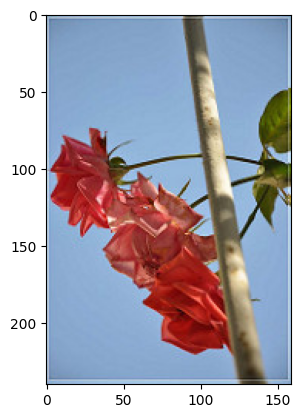

In [14]:
plt.imshow(rose_img);

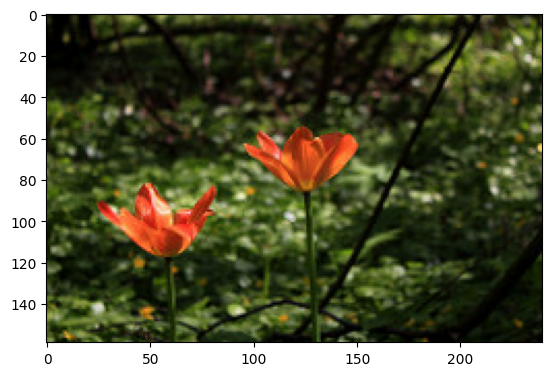

In [15]:
plt.imshow(tulip_img);

# **Data Augmentation**

In [16]:
image_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=40,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split = 0.3,
    rescale = 1/255
)

In [17]:
batch_size = 32
img_height = 256
img_width = 256

In [18]:
classes = ['daisy', 'rose', 'tulip', 'sunflower', 'dandelion']

In [19]:
training_data = image_gen.flow_from_directory(
    train_dir,
    classes = classes,
    subset = "training",
    class_mode="categorical",
    target_size = (img_width, img_height),
    batch_size = batch_size,
    shuffle = False
)

validation_data = image_gen.flow_from_directory(
    train_dir,
    classes = classes,
    subset = "validation",
    class_mode="categorical",
    target_size = (img_width, img_height),
    batch_size = batch_size,
    shuffle = False
)

Found 2418 images belonging to 5 classes.
Found 1034 images belonging to 5 classes.


In [20]:
image_shape = (256,256,3)

# **CNN Model**

In [21]:
model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
          
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())

model.add(Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [22]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 127, 127, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 62, 62, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 30, 30, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 594,501 (2.27 MB)

 Trainable params: 593,477 (2.26 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [23]:
early_stop = EarlyStopping(monitor='val_loss',patience=10)

In [24]:
results = model.fit(training_data,epochs=50,
                    validation_data=validation_data,
                    callbacks=[early_stop])

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 1/76 ━━━━━━━━━━━━━━━━━━━━ 36:34 29s/step - accuracy: 0.2812 - loss: 2.1709

I0000 00:00:1712761909.947398      93 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1712761909.970180      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 576ms/step - accuracy: 0.2125 - loss: 1.8227

W0000 00:00:1712761953.222983      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712761955.038825      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


76/76 ━━━━━━━━━━━━━━━━━━━━ 90s 814ms/step - accuracy: 0.2124 - loss: 1.8212 - val_accuracy: 0.1770 - val_loss: 1.7099
Epoch 2/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 46s 565ms/step - accuracy: 0.2090 - loss: 1.6246 - val_accuracy: 0.1770 - val_loss: 1.6512
Epoch 3/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 46s 567ms/step - accuracy: 0.1707 - loss: 1.6208 - val_accuracy: 0.1770 - val_loss: 1.6418
Epoch 4/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 46s 565ms/step - accuracy: 0.2838 - loss: 1.5994 - val_accuracy: 0.1934 - val_loss: 1.6104
Epoch 5/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 46s 571ms/step - accuracy: 0.2437 - loss: 1.6169 - val_accuracy: 0.2195 - val_loss: 1.5964
Epoch 6/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 46s 569ms/step - accuracy: 0.2636 - loss: 1.5995 - val_accuracy: 0.2437 - val_loss: 1.5738
Epoch 7/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 46s 565ms/step - accuracy: 0.2310 - loss: 1.6147 - val_accuracy: 0.2360 - val_loss: 1.5830
Epoch 8/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 46s 568ms/step - accuracy: 0.2530 - loss: 1.6033 - val_accuracy: 0.245

In [25]:
summary = pd.DataFrame(model.history.history)
summary.head(15)

,accuracy,loss,val_accuracy,val_loss
0,0.205128,1.703097,0.176983,1.709916
1,0.224979,1.617962,0.176983,1.651225
2,0.216294,1.611312,0.176983,1.641778
3,0.242763,1.609599,0.193424,1.610429
4,0.253929,1.606867,0.219536,1.596409
5,0.233251,1.606368,0.243714,1.573834
6,0.242349,1.607908,0.235977,1.583016
7,0.246485,1.603019,0.245648,1.573394
8,0.233251,1.603598,0.235977,1.576842
9,0.249380,1.602747,0.286267,1.543883


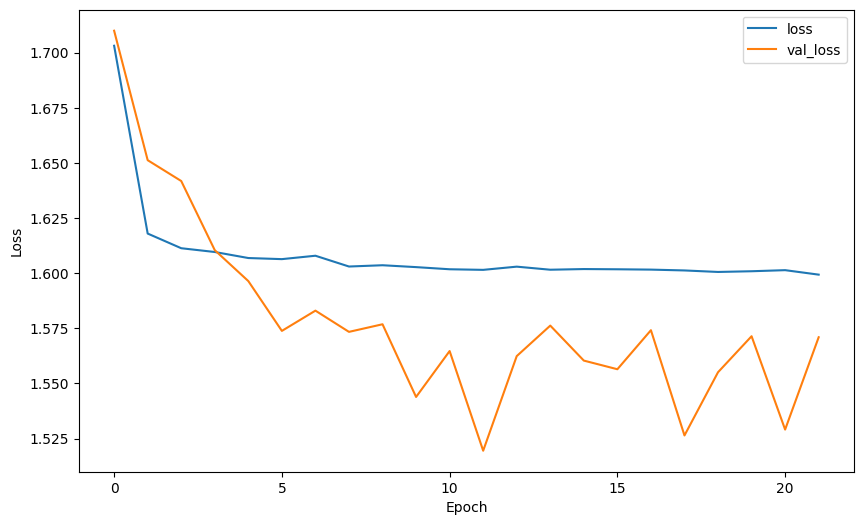

In [26]:
plt.figure(figsize=(10,6))
plt.plot(summary.loss, label="loss")
plt.plot(summary.val_loss, label="val_loss")
plt.legend(loc="upper right")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

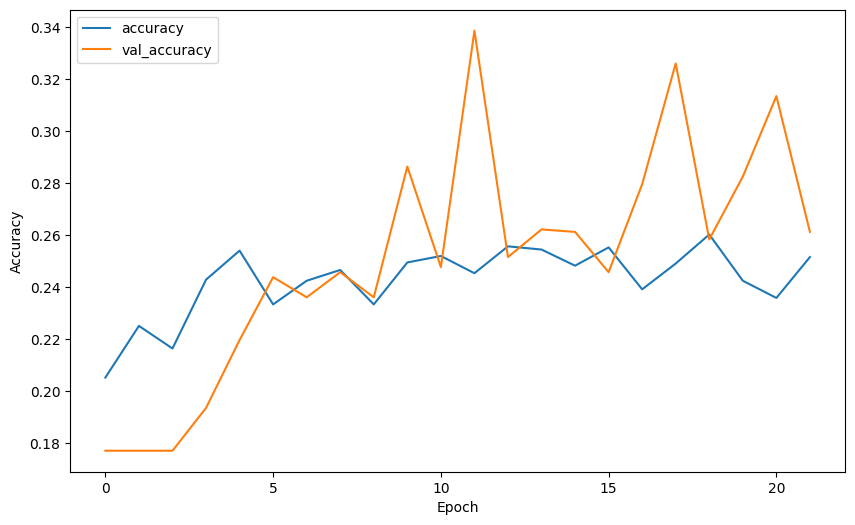

In [27]:
plt.figure(figsize=(10,6))
plt.plot(summary.accuracy, label="accuracy")
plt.plot(summary.val_accuracy, label="val_accuracy")
plt.legend(loc="upper left")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

In [28]:
model.evaluate(training_data)

76/76 ━━━━━━━━━━━━━━━━━━━━ 32s 419ms/step - accuracy: 0.0667 - loss: 1.6414


W0000 00:00:1712762984.179692      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


[1.5715646743774414, 0.2448304444551468]

In [29]:
model.evaluate(validation_data)

33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 412ms/step - accuracy: 0.0787 - loss: 1.6442


[1.5711383819580078, 0.25241780281066895]

In [30]:
pred_probabilities = model.predict(validation_data)
pred_probabilities

 1/33 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step

W0000 00:00:1712763000.513672      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 409ms/step


array([[0.1950317 , 0.19934794, 0.18782578, 0.16879188, 0.24900275],
       [0.16615981, 0.20543928, 0.2381343 , 0.1470613 , 0.24320526],
       [0.17491592, 0.1934392 , 0.21656355, 0.17941828, 0.23566297],
       ...,
       [0.17996347, 0.19388016, 0.18884218, 0.16315591, 0.2741583 ],
       [0.16541113, 0.17926809, 0.23579228, 0.17304459, 0.24648389],
       [0.18346792, 0.2020925 , 0.18694262, 0.17169514, 0.25580183]],
      dtype=float32)

In [31]:
validation_data.classes[:50]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=int32)

In [32]:
predictions = pred_probabilities > 0.5

In [33]:
#print(classification_report(validation_data.classes,predictions))

# **ConvNeXtTiny**

In [34]:
convex_model = Sequential()

pretrained_model= tf.keras.applications.ConvNeXtTiny(include_top=False,
                   input_shape=image_shape,
                   pooling='avg',
                   weights= 'imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

convex_model.add(pretrained_model)
convex_model.add(Flatten())
convex_model.add(Dense(512, activation='relu'))
convex_model.add(Dense(5, activation='softmax'))
convex_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

convex_model.summary()

111650432/111650432 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ convnext_tiny (Functional)      │ ?                      │    27,820,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,820,128 (106.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 27,820,128 (106.13 MB)

In [35]:
results = convex_model.fit(training_data,epochs=25,
                    validation_data=validation_data,
                    callbacks=[early_stop])

Epoch 1/25
 1/76 ━━━━━━━━━━━━━━━━━━━━ 28:19 23s/step - accuracy: 0.5625 - loss: 1.1368

W0000 00:00:1712763040.867066      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712763040.867446      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712763040.867869      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712763040.870877      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712763040.871280      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712763040.871738      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


20/76 ━━━━━━━━━━━━━━━━━━━━ 43s 779ms/step - accuracy: 0.1828 - loss: 2.5554

W0000 00:00:1712763055.747545      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712763055.747903      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712763055.748322      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712763055.749270      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712763055.749628      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712763055.749966      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712763055.750326      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712763055.750659      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - accuracy: 0.2083 - loss: 2.2295

W0000 00:00:1712763082.011176      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712763082.011467      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712763082.012006      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712763082.015090      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712763082.015443      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712763082.015855      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


76/76 ━━━━━━━━━━━━━━━━━━━━ 82s 786ms/step - accuracy: 0.2088 - loss: 2.2267 - val_accuracy: 0.3182 - val_loss: 1.7548
Epoch 2/25


W0000 00:00:1712763099.915090      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712763099.915558      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712763099.916017      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712763099.917088      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712763099.917493      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712763099.917864      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712763099.918250      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712763099.918626      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


76/76 ━━━━━━━━━━━━━━━━━━━━ 47s 581ms/step - accuracy: 0.4165 - loss: 1.5593 - val_accuracy: 0.4255 - val_loss: 1.4366
Epoch 3/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 47s 583ms/step - accuracy: 0.3723 - loss: 1.4929 - val_accuracy: 0.5861 - val_loss: 1.0798
Epoch 4/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 81s 581ms/step - accuracy: 0.5079 - loss: 1.2921 - val_accuracy: 0.5445 - val_loss: 1.1259
Epoch 5/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 47s 576ms/step - accuracy: 0.5510 - loss: 1.1360 - val_accuracy: 0.5648 - val_loss: 1.1152
Epoch 6/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 47s 579ms/step - accuracy: 0.6049 - loss: 1.0421 - val_accuracy: 0.6161 - val_loss: 0.9878
Epoch 7/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 47s 579ms/step - accuracy: 0.6088 - loss: 1.0772 - val_accuracy: 0.6025 - val_loss: 1.0244
Epoch 8/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 47s 578ms/step - accuracy: 0.5859 - loss: 1.0319 - val_accuracy: 0.6180 - val_loss: 0.9908
Epoch 9/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 47s 578ms/step - accuracy: 0.6422 - loss: 0.9683 - val_accuracy: 0.653

In [36]:
summary = pd.DataFrame(convex_model.history.history)
summary.head(15)

,accuracy,loss,val_accuracy,val_loss
0,0.245244,2.013990,0.318182,1.754841
1,0.418528,1.510676,0.425532,1.436595
2,0.458643,1.329870,0.586074,1.079797
3,0.522746,1.245606,0.544487,1.125874
4,0.548387,1.152860,0.564797,1.115216
5,0.581472,1.071870,0.616054,0.987824
6,0.556658,1.115106,0.602515,1.024368
7,0.611249,1.012061,0.617988,0.990796
8,0.626137,0.999351,0.653772,0.904506
9,0.633995,0.966730,0.618955,0.935025


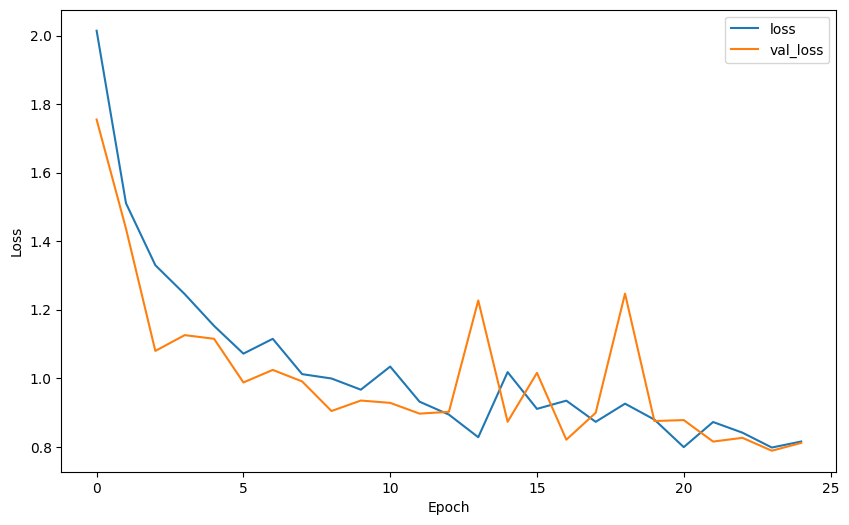

In [37]:
plt.figure(figsize=(10,6))
plt.plot(summary.loss, label="loss")
plt.plot(summary.val_loss, label="val_loss")
plt.legend(loc="upper right")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

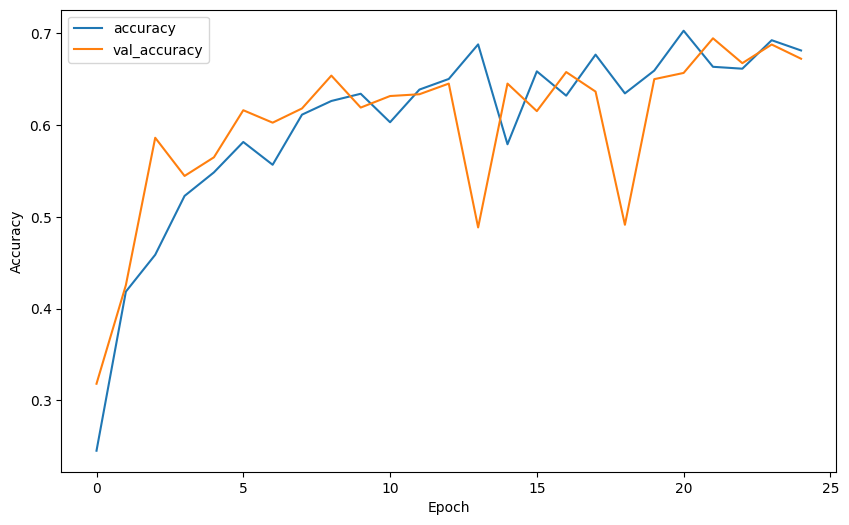

In [38]:
plt.figure(figsize=(10,6))
plt.plot(summary.accuracy, label="accuracy")
plt.plot(summary.val_accuracy, label="val_accuracy")
plt.legend(loc="upper left")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

In [39]:
convex_model.evaluate(training_data)
convex_model.evaluate(validation_data)

76/76 ━━━━━━━━━━━━━━━━━━━━ 35s 463ms/step - accuracy: 0.6539 - loss: 0.7876


W0000 00:00:1712764341.527259      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712764341.527670      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712764341.528124      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712764341.529144      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712764341.529509      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712764341.529891      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712764341.530260      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712764341.530639      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 421ms/step - accuracy: 0.6511 - loss: 0.8330


[0.8079633116722107, 0.6808510422706604]

In [40]:
pred_probabilities = convex_model.predict(validation_data)
pred_probabilities

 1/33 ━━━━━━━━━━━━━━━━━━━━ 2:24 5s/step

W0000 00:00:1712764362.003246      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712764362.003583      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712764362.004113      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712764362.007579      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712764362.008041      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712764362.008522      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


33/33 ━━━━━━━━━━━━━━━━━━━━ 22s 531ms/step


W0000 00:00:1712764379.002751      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712764379.003077      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712764379.003526      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712764379.004718      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712764379.005154      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712764379.005534      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712764379.005930      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712764379.006343      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


array([[0.10267812, 0.04939972, 0.07832967, 0.02887891, 0.7407136 ],
       [0.569347  , 0.00254295, 0.007548  , 0.01950165, 0.4010604 ],
       [0.9834637 , 0.00100387, 0.00114198, 0.00188013, 0.01251021],
       ...,
       [0.11331072, 0.03468906, 0.07236616, 0.05986639, 0.7197677 ],
       [0.26976037, 0.04846755, 0.0553727 , 0.02703355, 0.5993658 ],
       [0.14345399, 0.04445456, 0.07600714, 0.06309985, 0.67298454]],
      dtype=float32)

In [41]:
validation_data.classes[:50]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=int32)

In [42]:
predictions = pred_probabilities > 0.5

In [43]:
validation_data.classes

array([0, 0, 0, ..., 4, 4, 4], dtype=int32)

In [44]:
#print(classification_report(validation_data.classes,predictions))

# **Xception Model**

In [45]:
xception_model = Sequential()

pretrained_model= tf.keras.applications.Xception(include_top=False,
                   input_shape=image_shape,
                   pooling='avg',
                   weights= 'imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

xception_model.add(pretrained_model)
xception_model.add(Flatten())
xception_model.add(Dense(512, activation='relu'))
xception_model.add(Dense(5, activation='softmax'))
xception_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

xception_model.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ ?                      │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,861,480 (79.58 MB)

In [46]:
early_stop = EarlyStopping(monitor='val_loss',patience=10)

In [47]:
results = xception_model.fit(training_data,epochs=25,
                    validation_data=validation_data,
                    callbacks=[early_stop])

Epoch 1/25
 1/76 ━━━━━━━━━━━━━━━━━━━━ 36:08 29s/step - accuracy: 0.2812 - loss: 1.5273

W0000 00:00:1712764415.953688      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


33/76 ━━━━━━━━━━━━━━━━━━━━ 34s 804ms/step - accuracy: 0.3068 - loss: 2.5190

W0000 00:00:1712764441.744178      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 555ms/step - accuracy: 0.3995 - loss: 2.0029

W0000 00:00:1712764461.665495      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


76/76 ━━━━━━━━━━━━━━━━━━━━ 95s 885ms/step - accuracy: 0.4011 - loss: 1.9953 - val_accuracy: 0.7485 - val_loss: 0.7241
Epoch 2/25


W0000 00:00:1712764482.411440      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


76/76 ━━━━━━━━━━━━━━━━━━━━ 48s 587ms/step - accuracy: 0.7301 - loss: 0.7492 - val_accuracy: 0.7698 - val_loss: 0.5970
Epoch 3/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 48s 593ms/step - accuracy: 0.7743 - loss: 0.5983 - val_accuracy: 0.7031 - val_loss: 0.7531
Epoch 4/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 48s 596ms/step - accuracy: 0.7979 - loss: 0.5283 - val_accuracy: 0.8095 - val_loss: 0.4988
Epoch 5/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 47s 587ms/step - accuracy: 0.8392 - loss: 0.4262 - val_accuracy: 0.8056 - val_loss: 0.5038
Epoch 6/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 48s 595ms/step - accuracy: 0.8335 - loss: 0.4323 - val_accuracy: 0.8191 - val_loss: 0.5252
Epoch 7/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 47s 583ms/step - accuracy: 0.8397 - loss: 0.4291 - val_accuracy: 0.8346 - val_loss: 0.4232
Epoch 8/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 48s 587ms/step - accuracy: 0.8798 - loss: 0.3471 - val_accuracy: 0.8337 - val_loss: 0.4570
Epoch 9/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 48s 589ms/step - accuracy: 0.8383 - loss: 0.4261 - val_accuracy: 0.819

In [48]:
summary = pd.DataFrame(xception_model.history.history)
summary.head(15)

,accuracy,loss,val_accuracy,val_loss
0,0.517370,1.414590,0.748549,0.724132
1,0.724152,0.735103,0.769826,0.597013
2,0.786600,0.572663,0.703095,0.753062
3,0.814723,0.509144,0.809478,0.498780
4,0.808106,0.497800,0.805609,0.503758
5,0.854839,0.399345,0.819149,0.525159
6,0.843672,0.421149,0.834623,0.423153
7,0.877171,0.347027,0.833656,0.457022
8,0.860629,0.381531,0.819149,0.512848
9,0.878412,0.346212,0.830754,0.466368


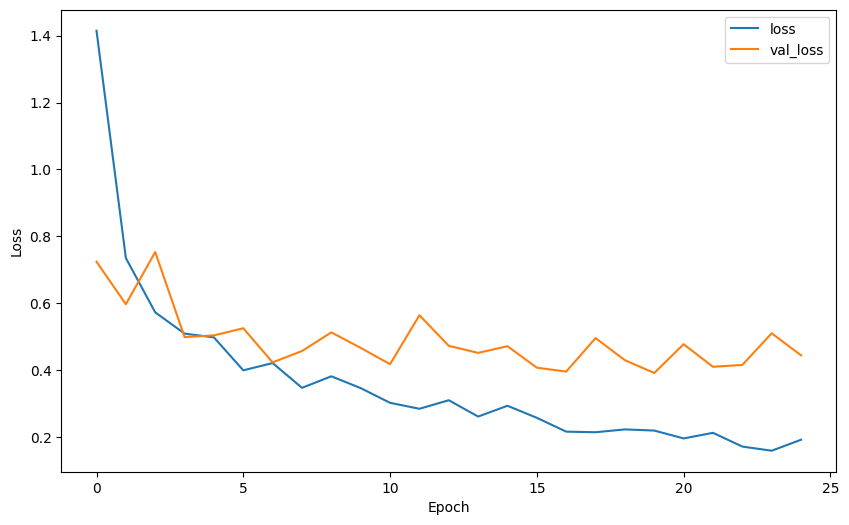

In [49]:
plt.figure(figsize=(10,6))
plt.plot(summary.loss, label="loss")
plt.plot(summary.val_loss, label="val_loss")
plt.legend(loc="upper right")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

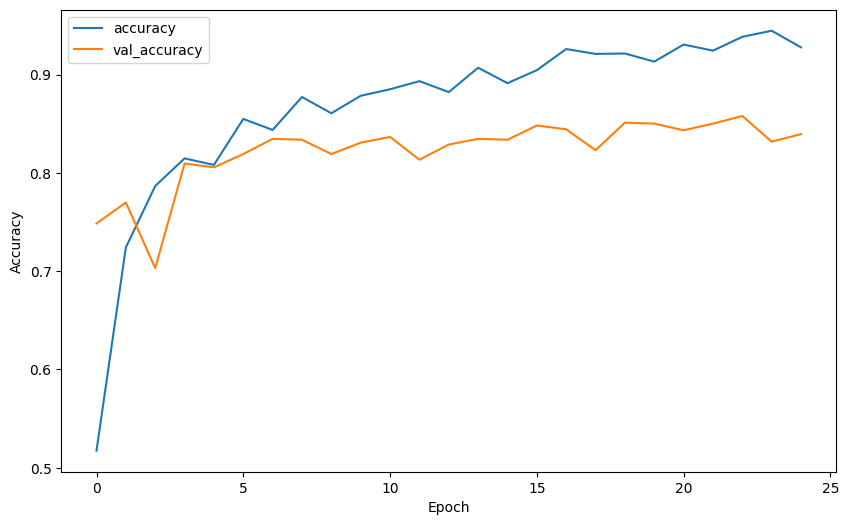

In [50]:
plt.figure(figsize=(10,6))
plt.plot(summary.accuracy, label="accuracy")
plt.plot(summary.val_accuracy, label="val_accuracy")
plt.legend(loc="upper left")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

In [51]:
xception_model.evaluate(training_data)

76/76 ━━━━━━━━━━━━━━━━━━━━ 35s 452ms/step - accuracy: 0.9438 - loss: 0.1659


W0000 00:00:1712765716.278143      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


[0.1393802911043167, 0.9557485580444336]

In [52]:
xception_model.evaluate(validation_data)

33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 418ms/step - accuracy: 0.8388 - loss: 0.4250


[0.424122154712677, 0.8413926362991333]

In [53]:
pred_probabilities = xception_model.predict(validation_data)
pred_probabilities

 2/33 ━━━━━━━━━━━━━━━━━━━━ 5s 180ms/step

W0000 00:00:1712765737.051559      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


33/33 ━━━━━━━━━━━━━━━━━━━━ 19s 484ms/step


W0000 00:00:1712765752.544241      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


array([[9.9144220e-01, 6.3692161e-04, 2.0224405e-03, 5.6070169e-03,
        2.9150833e-04],
       [9.7912359e-01, 7.0362112e-05, 2.8853873e-03, 3.5436131e-04,
        1.7566342e-02],
       [9.9948227e-01, 5.9259701e-06, 2.0695181e-04, 2.1360161e-04,
        9.1110523e-05],
       ...,
       [9.5919881e-05, 7.9688368e-07, 8.9729729e-06, 4.6233574e-05,
        9.9984801e-01],
       [7.8125941e-03, 8.0383892e-05, 2.5361140e-05, 4.2747438e-02,
        9.4933426e-01],
       [2.6750346e-04, 1.5846872e-05, 5.4995931e-04, 1.7454449e-05,
        9.9914920e-01]], dtype=float32)

In [54]:
validation_data.classes[:50]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=int32)

In [55]:
predictions = pred_probabilities > 0.5

In [56]:
from sklearn.metrics import classification_report
#print(classification_report(validation_data.classes,predictions))

# **VCG16 Model**

In [57]:
vcg16_model = Sequential()

pretrained_model= tf.keras.applications.VGG16(include_top=False,
                   input_shape=image_shape,
                   pooling='avg',
                   weights= 'imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

vcg16_model.add(pretrained_model)
vcg16_model.add(Flatten())
vcg16_model.add(Dense(512, activation='relu'))
vcg16_model.add(Dense(5, activation='softmax'))
vcg16_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

vcg16_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [58]:
early_stop = EarlyStopping(monitor='val_loss',patience=10)

In [59]:
results = vcg16_model.fit(training_data,epochs=25,
                    validation_data=validation_data,
                    callbacks=[early_stop])

Epoch 1/25
 1/76 ━━━━━━━━━━━━━━━━━━━━ 1:02:36 50s/step - accuracy: 0.9375 - loss: 1.2423

W0000 00:00:1712765811.649481      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 769ms/step - accuracy: 0.3520 - loss: 1.7949

W0000 00:00:1712765871.224231      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


76/76 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.3516 - loss: 1.7942 - val_accuracy: 0.3694 - val_loss: 1.5373
Epoch 2/25


W0000 00:00:1712765903.289903      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


76/76 ━━━━━━━━━━━━━━━━━━━━ 48s 596ms/step - accuracy: 0.3814 - loss: 1.4410 - val_accuracy: 0.4101 - val_loss: 1.3836
Epoch 3/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 48s 591ms/step - accuracy: 0.5417 - loss: 1.1475 - val_accuracy: 0.4478 - val_loss: 1.3700
Epoch 4/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 48s 590ms/step - accuracy: 0.5765 - loss: 1.0970 - val_accuracy: 0.5841 - val_loss: 1.0159
Epoch 5/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 47s 585ms/step - accuracy: 0.6070 - loss: 0.9832 - val_accuracy: 0.5416 - val_loss: 1.1302
Epoch 6/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 48s 591ms/step - accuracy: 0.6844 - loss: 0.8658 - val_accuracy: 0.7070 - val_loss: 0.8323
Epoch 7/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 48s 589ms/step - accuracy: 0.6767 - loss: 0.8733 - val_accuracy: 0.6518 - val_loss: 0.8766
Epoch 8/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 48s 586ms/step - accuracy: 0.6979 - loss: 0.7789 - val_accuracy: 0.6712 - val_loss: 0.8643
Epoch 9/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 48s 596ms/step - accuracy: 0.7104 - loss: 0.7760 - val_accuracy: 0.679

In [60]:
summary = pd.DataFrame(vcg16_model.history.history)
summary.head(15)

,accuracy,loss,val_accuracy,val_loss
0,0.318859,1.740520,0.369439,1.537313
1,0.456989,1.308388,0.410058,1.383551
2,0.551282,1.124718,0.447776,1.370001
3,0.583127,1.081964,0.584139,1.015923
4,0.601323,0.988098,0.541586,1.130167
5,0.621175,0.993151,0.706963,0.832330
6,0.668734,0.876802,0.651838,0.876627
7,0.682796,0.817999,0.671180,0.864349
8,0.677006,0.833908,0.679884,0.792184
9,0.669975,0.833756,0.728240,0.741812


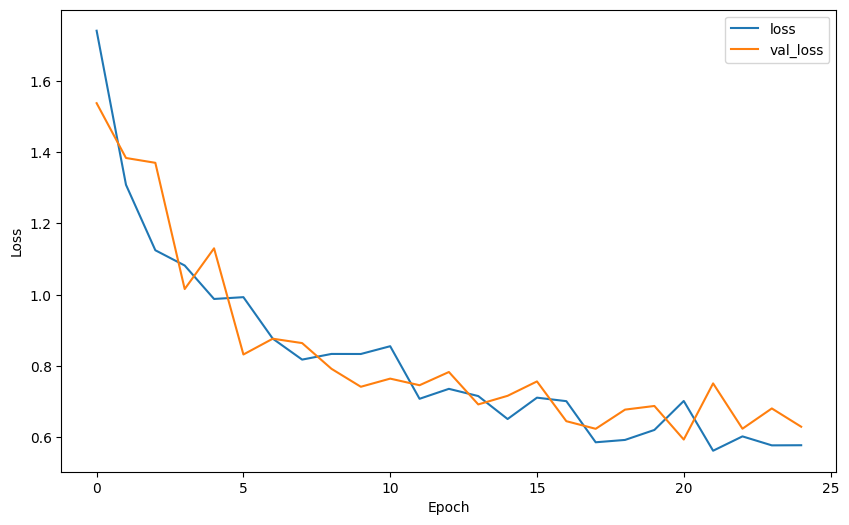

In [61]:
plt.figure(figsize=(10,6))
plt.plot(summary.loss, label="loss")
plt.plot(summary.val_loss, label="val_loss")
plt.legend(loc="upper right")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

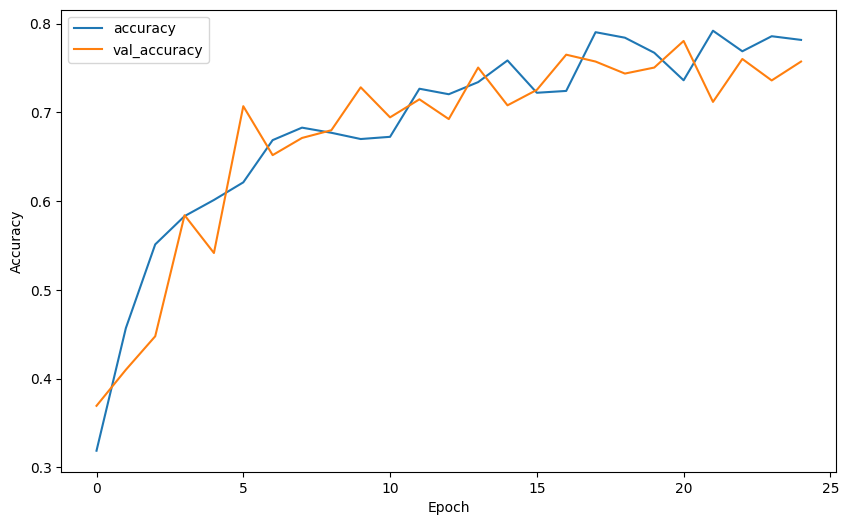

In [62]:
plt.figure(figsize=(10,6))
plt.plot(summary.accuracy, label="accuracy")
plt.plot(summary.val_accuracy, label="val_accuracy")
plt.legend(loc="upper left")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

In [63]:
vcg16_model.evaluate(training_data)
vcg16_model.evaluate(validation_data)

76/76 ━━━━━━━━━━━━━━━━━━━━ 33s 436ms/step - accuracy: 0.7089 - loss: 0.7827
33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 423ms/step - accuracy: 0.7068 - loss: 0.7646


[0.6137681603431702, 0.7678917050361633]

In [64]:
pred_probabilities = vcg16_model.predict(validation_data)
pred_probabilities

 2/33 ━━━━━━━━━━━━━━━━━━━━ 5s 181ms/step

W0000 00:00:1712767159.634088      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 422ms/step


W0000 00:00:1712767173.148680      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


array([[4.24864814e-02, 7.67799618e-04, 2.06610258e-03, 2.86730137e-02,
        9.26006675e-01],
       [1.19394995e-01, 2.88033307e-01, 9.59028006e-02, 2.75630325e-01,
        2.21038610e-01],
       [5.43374181e-01, 9.77185927e-03, 4.32527252e-03, 4.15756226e-01,
        2.67724302e-02],
       ...,
       [2.10348461e-02, 6.46726489e-02, 6.41615033e-01, 9.95362252e-02,
        1.73141181e-01],
       [1.06155910e-02, 4.58176062e-02, 4.70974203e-03, 5.60224243e-03,
        9.33254898e-01],
       [1.43293291e-03, 7.86248711e-04, 5.93829725e-04, 2.62721558e-03,
        9.94559705e-01]], dtype=float32)

In [65]:
validation_data.classes[:50]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=int32)

In [66]:
predictions = pred_probabilities > 0.5

In [67]:
validation_data.classes

array([0, 0, 0, ..., 4, 4, 4], dtype=int32)

In [68]:
#print(classification_report(validation_data.classes,predictions))

# **MobileNetV2 Model**

In [69]:
mobilenet_model = Sequential()

pretrained_model= tf.keras.applications.MobileNetV2(include_top=False,
                   input_shape=image_shape,
                   pooling='avg',
                   weights= 'imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

mobilenet_model.add(pretrained_model)
mobilenet_model.add(Flatten())
mobilenet_model.add(Dense(512, activation='relu'))
mobilenet_model.add(Dense(5, activation='softmax'))
mobilenet_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

mobilenet_model.summary()

/tmp/ipykernel_26/2532539849.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  pretrained_model= tf.keras.applications.MobileNetV2(include_top=False,


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ ?                      │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [70]:
early_stop = EarlyStopping(monitor='val_loss',patience=10)

In [71]:
results = mobilenet_model.fit(training_data,epochs=25,
                    validation_data=validation_data,
                    callbacks=[early_stop])

Epoch 1/25
 1/76 ━━━━━━━━━━━━━━━━━━━━ 21:28 17s/step - accuracy: 0.3438 - loss: 1.5183

W0000 00:00:1712767204.097441      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


51/76 ━━━━━━━━━━━━━━━━━━━━ 13s 536ms/step - accuracy: 0.4165 - loss: 3.2240

W0000 00:00:1712767230.818082      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


75/76 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - accuracy: 0.4468 - loss: 2.7757

W0000 00:00:1712767243.045151      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


76/76 ━━━━━━━━━━━━━━━━━━━━ 74s 759ms/step - accuracy: 0.4490 - loss: 2.7468 - val_accuracy: 0.7244 - val_loss: 0.7188
Epoch 2/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 47s 573ms/step - accuracy: 0.7450 - loss: 0.6653 - val_accuracy: 0.7814 - val_loss: 0.6106
Epoch 3/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 47s 577ms/step - accuracy: 0.7691 - loss: 0.6548 - val_accuracy: 0.7814 - val_loss: 0.5812
Epoch 4/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 47s 580ms/step - accuracy: 0.8190 - loss: 0.4487 - val_accuracy: 0.8143 - val_loss: 0.4908
Epoch 5/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 47s 578ms/step - accuracy: 0.8341 - loss: 0.4427 - val_accuracy: 0.8240 - val_loss: 0.4433
Epoch 6/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 47s 577ms/step - accuracy: 0.8621 - loss: 0.3869 - val_accuracy: 0.8453 - val_loss: 0.4225
Epoch 7/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 46s 571ms/step - accuracy: 0.8817 - loss: 0.3382 - val_accuracy: 0.8095 - val_loss: 0.5080
Epoch 8/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 46s 573ms/step - accuracy: 0.8756 - loss: 0.3225 - val_accuracy: 0.859

In [72]:
summary = pd.DataFrame(mobilenet_model.history.history)
summary.head(15)

,accuracy,loss,val_accuracy,val_loss
0,0.531844,1.663351,0.724371,0.718760
1,0.753929,0.636733,0.781431,0.610628
2,0.789495,0.590054,0.781431,0.581250
3,0.836228,0.436969,0.814313,0.490819
4,0.822994,0.473762,0.823985,0.443275
5,0.852771,0.398606,0.845261,0.422520
6,0.872622,0.342872,0.809478,0.508049
7,0.880066,0.326426,0.859768,0.370966
8,0.889992,0.282909,0.862669,0.384262
9,0.914806,0.246606,0.875242,0.356554


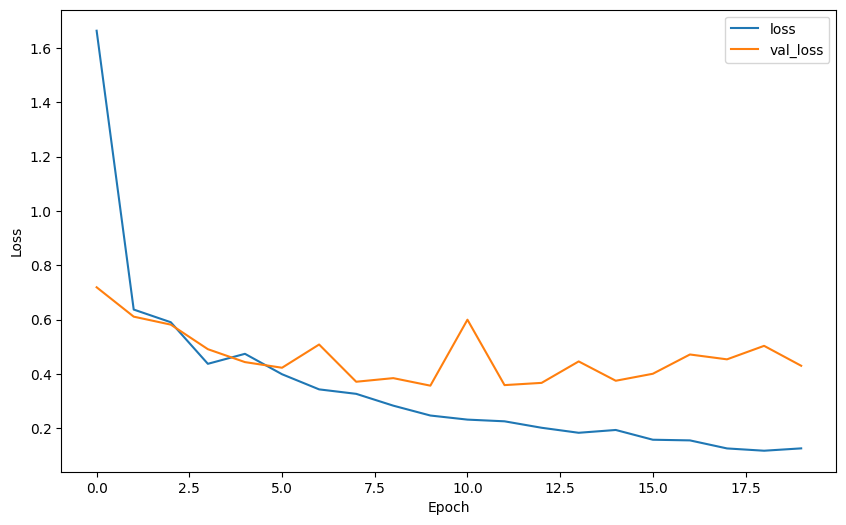

In [73]:
plt.figure(figsize=(10,6))
plt.plot(summary.loss, label="loss")
plt.plot(summary.val_loss, label="val_loss")
plt.legend(loc="upper right")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

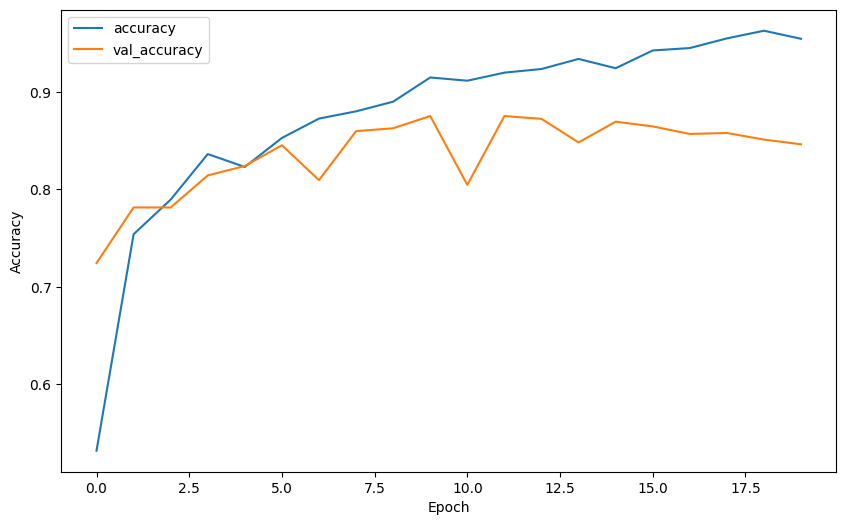

In [74]:
plt.figure(figsize=(10,6))
plt.plot(summary.accuracy, label="accuracy")
plt.plot(summary.val_accuracy, label="val_accuracy")
plt.legend(loc="upper left")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

In [75]:
mobilenet_model.evaluate(training_data)

76/76 ━━━━━━━━━━━━━━━━━━━━ 35s 454ms/step - accuracy: 0.9609 - loss: 0.1036


W0000 00:00:1712768191.119266      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


[0.0985705703496933, 0.9640198349952698]

In [76]:
mobilenet_model.evaluate(validation_data)

33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 417ms/step - accuracy: 0.8588 - loss: 0.4339


[0.4345414936542511, 0.8491296172142029]

In [77]:
pred_probabilities = mobilenet_model.predict(validation_data)
pred_probabilities

 1/33 ━━━━━━━━━━━━━━━━━━━━ 1:55 4s/step

W0000 00:00:1712768213.117899      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 517ms/step


array([[9.9928761e-01, 6.4081018e-05, 3.2361571e-04, 3.0369617e-04,
        2.0969886e-05],
       [7.5471646e-01, 5.2201999e-03, 6.2936620e-04, 1.5507245e-01,
        8.4361479e-02],
       [9.9780494e-01, 2.5221434e-05, 1.0400548e-05, 1.7875432e-03,
        3.7200071e-04],
       ...,
       [9.3171813e-08, 3.4887171e-07, 1.4651435e-08, 4.0160694e-06,
        9.9999547e-01],
       [1.7783744e-03, 1.8893426e-03, 2.1132279e-05, 1.3589892e-03,
        9.9495214e-01],
       [6.6526542e-07, 7.5566090e-06, 1.2025712e-05, 2.6497386e-05,
        9.9995327e-01]], dtype=float32)

In [78]:
validation_data.classes[:1000]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [79]:
predictions = pred_probabilities > 0.5

In [80]:
validation_data.classes

array([0, 0, 0, ..., 4, 4, 4], dtype=int32)

In [81]:
#print(classification_report(validation_data.classes,predictions))

# **ResNet152**

In [82]:
resnet_model152 = Sequential()

pretrained_model= tf.keras.applications.ResNet152(include_top=False,
                   input_shape=image_shape,
                   pooling='avg',
                   weights= 'imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model152.add(pretrained_model)
resnet_model152.add(Flatten())
resnet_model152.add(Dense(512, activation='relu'))
resnet_model152.add(Dense(5, activation='softmax'))
resnet_model152.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

resnet_model152.summary()

234698864/234698864 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet152 (Functional)          │ ?                      │    58,370,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,370,944 (222.67 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 58,370,944 (222.67 MB)

In [83]:
results = resnet_model152.fit(training_data,epochs=25,
                    validation_data=validation_data,
                    callbacks=[early_stop])

Epoch 1/25


W0000 00:00:1712768286.662264      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


12/76 ━━━━━━━━━━━━━━━━━━━━ 1:34 1s/step - accuracy: 0.1221 - loss: 2.8853  

W0000 00:00:1712768302.961640      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 568ms/step - accuracy: 0.2043 - loss: 2.3666

W0000 00:00:1712768340.983488      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


76/76 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.2048 - loss: 2.3627 - val_accuracy: 0.2660 - val_loss: 1.6955
Epoch 2/25


W0000 00:00:1712768362.522603      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


76/76 ━━━━━━━━━━━━━━━━━━━━ 50s 621ms/step - accuracy: 0.2746 - loss: 2.0420 - val_accuracy: 0.2563 - val_loss: 1.7273
Epoch 3/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 50s 611ms/step - accuracy: 0.2324 - loss: 1.7136 - val_accuracy: 0.2892 - val_loss: 1.7225
Epoch 4/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 50s 610ms/step - accuracy: 0.3522 - loss: 1.5664 - val_accuracy: 0.3240 - val_loss: 1.5073
Epoch 5/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 50s 613ms/step - accuracy: 0.2616 - loss: 1.6136 - val_accuracy: 0.2273 - val_loss: 1.5668
Epoch 6/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 50s 611ms/step - accuracy: 0.2654 - loss: 1.5966 - val_accuracy: 0.3037 - val_loss: 1.5218
Epoch 7/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 50s 612ms/step - accuracy: 0.2888 - loss: 1.6060 - val_accuracy: 0.2466 - val_loss: 1.5427
Epoch 8/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 50s 614ms/step - accuracy: 0.2340 - loss: 1.5991 - val_accuracy: 0.3559 - val_loss: 1.5170
Epoch 9/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 50s 611ms/step - accuracy: 0.3210 - loss: 1.5427 - val_accuracy: 0.343

In [84]:
summary = pd.DataFrame(resnet_model152.history.history)
summary.head()

,accuracy,loss,val_accuracy,val_loss
0,0.240695,2.071820,0.265957,1.695467
1,0.260546,2.046716,0.256286,1.727311
2,0.243590,1.705830,0.289168,1.722534
3,0.243590,1.663127,0.323985,1.507336
4,0.247312,1.642132,0.227273,1.566837


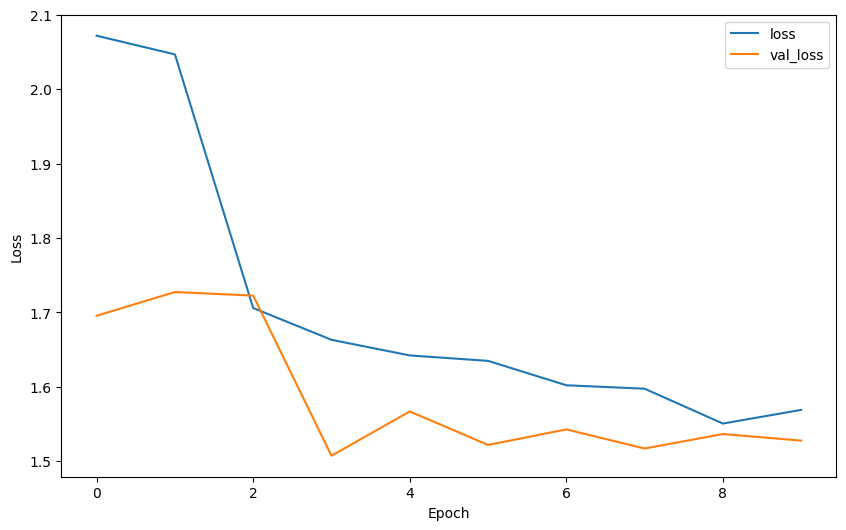

In [85]:
plt.figure(figsize=(10,6))
plt.plot(summary.loss, label="loss")
plt.plot(summary.val_loss, label="val_loss")
plt.legend(loc="upper right")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

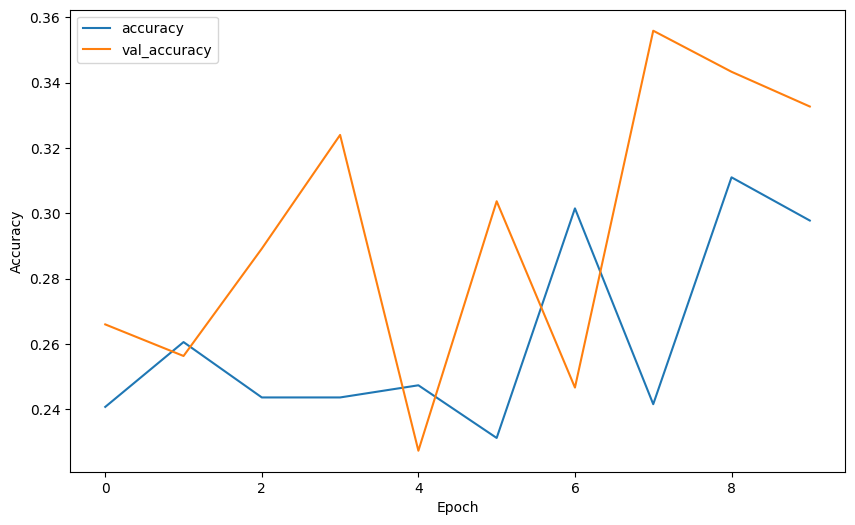

In [86]:
plt.figure(figsize=(10,6))
plt.plot(summary.accuracy, label="accuracy")
plt.plot(summary.val_accuracy, label="val_accuracy")
plt.legend(loc="upper left")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

In [87]:
resnet_model152.evaluate(training_data)
resnet_model152.evaluate(validation_data)

76/76 ━━━━━━━━━━━━━━━━━━━━ 38s 498ms/step - accuracy: 0.3394 - loss: 1.5047


W0000 00:00:1712768856.858926      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 431ms/step - accuracy: 0.3457 - loss: 1.4849


[1.525420904159546, 0.3336557149887085]

In [88]:
pred_probabilities = resnet_model152.predict(validation_data)
pred_probabilities

 1/33 ━━━━━━━━━━━━━━━━━━━━ 5:53 11s/step

W0000 00:00:1712768885.462027      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


33/33 ━━━━━━━━━━━━━━━━━━━━ 35s 745ms/step


W0000 00:00:1712768909.309763      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


array([[0.12970062, 0.17169616, 0.21113133, 0.1939653 , 0.2935066 ],
       [0.28360802, 0.19960299, 0.23949054, 0.19630374, 0.08099478],
       [0.21720853, 0.20344815, 0.23686928, 0.20457852, 0.13789542],
       ...,
       [0.18061417, 0.19616482, 0.23128487, 0.20526505, 0.18667111],
       [0.17225635, 0.19690831, 0.23789968, 0.18179803, 0.21113764],
       [0.14601801, 0.18192899, 0.22078994, 0.19682465, 0.25443843]],
      dtype=float32)

In [89]:
validation_data.classes[:50]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=int32)

In [90]:
predictions = pred_probabilities > 0.5

In [91]:
validation_data.classes

array([0, 0, 0, ..., 4, 4, 4], dtype=int32)

In [92]:
#print(classification_report(validation_data.classes,predictions))